**кластеризатор MeanShift**

Евгений Борисов <esborisov@sevsu.ru>

# генерируем датасет

In [1]:
import numpy as np
from numpy import random as rng
from sklearn.datasets import make_blobs

In [2]:
n_samples = 500
n_clst = 4 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=rng.uniform(size=n_clst)+.7
    )
display( X.shape )

(500, 2)

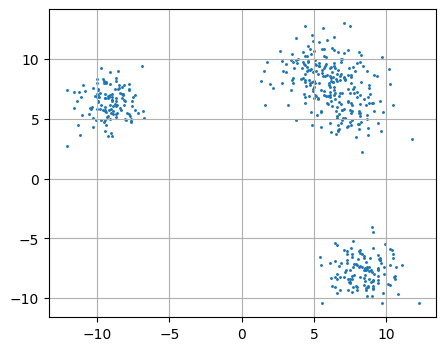

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,4))
plt.scatter(X[:,0],X[:,1],s=1.2)
plt.grid()

# модель кластеризатора

1. задаём радиус кластера r
2. помечаем все точки как некластеризированые
3. выбираем рандомно точку из некластеризированых как центроид
4. собираем кластер радиуса r из некластеризированых точек вокруг центроида
5. пересчитываем центроид как среднее по кластеру
6. если позиция центроида изменилась то переход на п.4 иначе переход на след.п.
7. запоминаем центроид помечаем точки центройда как кластеризированые
8. если есть ещё некластеризированые точки то переход на п.3. иначе переход на след.п.
9. конец работы

In [4]:
from sklearn.metrics.pairwise import euclidean_distances as metric

In [5]:
from tqdm.auto import tqdm

In [6]:
class MeanShiftClustering:
    
    def __init__(self, cluster_radius=1., metric=metric ):
        assert cluster_radius>0.
        self._metric = metric
        self._r = cluster_radius
        self._mu = []
    
    def fit(self,X, min_delta=1e-7,max_iter=50):
        assert len(X)>1
        assert len(X.shape)==2
        assert min_delta>0.
        return self._build_cluster(X,min_delta,max_iter)

    def _build_cluster(self,X,min_delta,max_iter):
        if len(X)<2: return self
        self._init_centroid(X) # создаём новый центроид mu для точек X
        for _ in range(max_iter): # двигаем центроид формируем кластер радиуса r
            idx = self._assemble_cluster(X) # собираем кластер вокруг центроида mu 
            mu_shift = self._move_centroid(X[idx,:]) # сдвигаем центроид
            if mu_shift<min_delta: break # сдвиг центройда незначительный
        X = X[ np.delete( np.arange(len(X)), idx ), : ] # выкидываем обработанные точки
        return self._build_cluster( X,  min_delta,max_iter) # рекуррентно повторяем для оставщихся
        
    def _assemble_cluster(self,X,n_mu=-1): # собираем кластер вокруг центроида mu 
        assert n_mu<len(self._mu)
        d = self._metric( self._mu[n_mu], X ).flatten() # расстояние всех X до центроида mu
        return np.arange( len(X) )[ d<self._r ] # индексы X с расстоянием до mu меньше r
    
    def _init_centroid(self,X): # случайно выбираем новый центроид mu из точек X
        n = rng.randint( len(X), size=1 )
        self._mu.append( X[n,:] )
        return self
        
    def _move_centroid(self,X): # сдвигаем центроид в центр кластера
        mu = self._mu[-1] # сохраняем предыдущее положение центроида в кластере X
        self._mu[-1] = X.mean(axis=0,keepdims=True) # сдвигаем центроид в центр кластера X
        return self._metric(mu,self._mu[-1]) # считаем сдвиг центройда 

    
    def predict(self,X): # кластеризация точек X
        assert len(self._mu)>0
        d = self._metric( self.centroid, X ) # расстояние всех X до центроидов mu
        # разбираем точки по кластерам к ближайшим центройдам
        return np.argmin( d, axis=0 )
    
    @property
    def centroid(self): return np.vstack( self._mu )

# тестируем

In [11]:
# обучаем модель
model = MeanShiftClustering( cluster_radius=3., metric=metric ).fit(X)

In [12]:
predicted = model.predict(X)
mu = model.centroid
display(mu.shape)

(16, 2)

In [13]:
# оценка результата
from sklearn.metrics import silhouette_score

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X,predicted)

0.22612218695208752

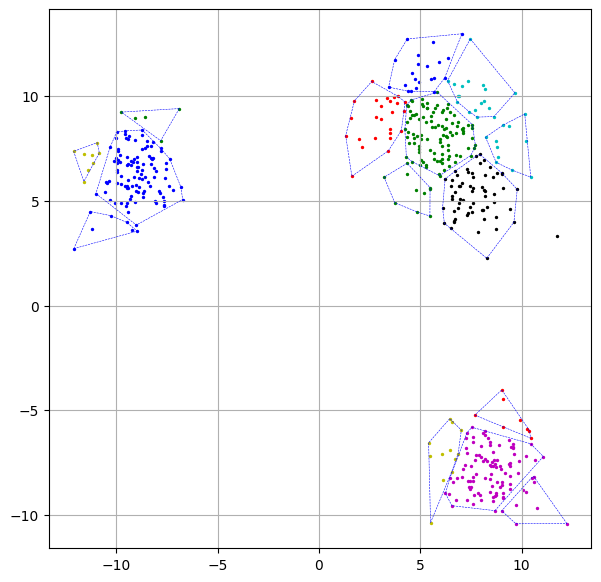

In [14]:
from scipy.spatial import ConvexHull

color_list = 'bgrcmyk'*10 

def hull(x):
    if len(x)<3: return
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    plt.plot(x[v,0],x[v,1],'--',lw=.4,c='b')

def plot(X,mu,y,figsize=(7,7)):
    plt.figure(figsize=figsize)
    for j in set(y): 
        plt.scatter( x=X[y==j,0], y=X[y==j,1], s=2,c=color_list[j] )
        #plt.scatter( x=mu[j,0], y=mu[j,1], s=9, marker='*',c='r' )
        hull(X[y==j])
    plt.grid()
    
plot(X,mu,predicted)